In [3]:
#!pip install pandas numpy matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


#df_cases = pd.read_csv('covid19/cases_by_specimen_date.csv')
#df_hospital_adm = pd.read_csv('covid19/patients_admitted_to_hospital.csv')
#df_hospital_occ = pd.read_csv('covid19/patients_in_hospital.csv')

#print("cases data shape:", df_cases.shape)
#print("hospital admissions shape:", df_hospital_adm.shape)
#print("hospital occupancy shape:", df_hospital_occ.shape)
#print(df_cases.head())

# Hisorical parameteres

In [36]:
# basic reproduction number from literature
# original covid-19 strain (wuhan): R0 = 2.5-3.5
# uk first wave: R0 ≈ 3.0
R0_literature = 3.0
#source: WHO reports, early 2020 studies

# england population
population = 56_000_000

# severity probabilitiesnbased on uk data from 2020 (pre-vaccination)
p_h = 0.93  # 93% mild cases (home recovery)
p_s = 0.05  # 5% hospitalization required
p_c = 0.02  # 2% ICU admission

#source: NHS England data, Imperial College reports


In [37]:

# recovery rates based on clinical data from 2020
beta_h = 1/10  # 10 days home recovery
beta_s = 1/12  # 12 days hospital stay
beta_c = 1/20  # 20 days ICU stay

# weighted average recovery rate
beta_weighted = p_h * beta_h + p_s * beta_s + p_c * beta_c

print("\nrecovery rates:")
print(f"beta_h:              {beta_h:.4f}  ({1/beta_h:.0f} days home)")
print(f"beta_s:              {beta_s:.4f}  ({1/beta_s:.0f} days hospital)")
print(f"beta_c:              {beta_c:.4f}  ({1/beta_c:.0f} days ICU)")
print(f"beta_weighted:       {beta_weighted:.4f}")
#source: WHO reports


recovery rates:
beta_h:              0.1000  (10 days home)
beta_s:              0.0833  (12 days hospital)
beta_c:              0.0500  (20 days ICU)
beta_weighted:       0.0982


In [38]:
# transmission parameters

# pre-lockdown (normal behavior)
c_normal = 15.0  # daily contacts (literature: 10-20)

# calculate alpha from: R0 = (c * alpha) / beta
alpha_normal = (R0_literature * beta_weighted) / c_normal

print("\npre-lockdown transmission:")
print(f"c (contacts/day):    {c_normal:.2f}")
print(f"alpha (infection prob): {alpha_normal:.6f}")

# verify R0
R_calculated = (c_normal * alpha_normal) / beta_weighted
print(f"R0 (calculated):     {R_calculated:.2f}")



pre-lockdown transmission:
c (contacts/day):    15.00
alpha (infection prob): 0.019633
R0 (calculated):     3.00


In [39]:
#lockdown parameters

# UK lockdown started March 23, 2020
# contacts reduced by ~80% (from 15 to 3)
# transmission also reduced by ~20% (masks, distancing)

c_lockdown = 3.0
alpha_lockdown = alpha_normal * 0.8

R_lockdown = (c_lockdown * alpha_lockdown) / beta_weighted

print("\nlockdown transmission:")
print(f"c (contacts/day):    {c_lockdown:.2f}")
print(f"alpha (infection prob): {alpha_lockdown:.6f}")
print(f"R (effective):       {R_lockdown:.2f}")


lockdown transmission:
c (contacts/day):    3.00
alpha (infection prob): 0.015707
R (effective):       0.48


## lockdown timeline (UK first wave)

In [40]:

# assuming simulation starts Feb 15, 2020 (day 0)
lockdown_start = 37    # March 23, 2020
lockdown_relax = 77    # May 10, 2020 (partial easing)
lockdown_end = 137     # July 4, 2020 (major reopening)

# parameters during different phases
c_relax = 6.0          # partial reopening
alpha_relax = alpha_normal * 0.85

c_end = 10.0           # post-lockdown (still cautious)
alpha_end = alpha_normal * 0.9

print("\nlockdown timeline (days from Feb 15, 2020):")
print(f"day {lockdown_start}:  lockdown starts (March 23)")
print(f"             c = {c_lockdown}, alpha = {alpha_lockdown:.6f}")
print(f"day {lockdown_relax}:  partial easing (May 10)")
print(f"             c = {c_relax}, alpha = {alpha_relax:.6f}")
print(f"day {lockdown_end}: major reopening (July 4)")
print(f"             c = {c_end}, alpha = {alpha_end:.6f}")


lockdown timeline (days from Feb 15, 2020):
day 37:  lockdown starts (March 23)
             c = 3.0, alpha = 0.015707
day 77:  partial easing (May 10)
             c = 6.0, alpha = 0.016688
day 137: major reopening (July 4)
             c = 10.0, alpha = 0.017670


# Anylogic parameteres

In [41]:
# create events table

params_df = pd.DataFrame({
    'Parameter': ['population', 'v0', 'r0', 'vaccinationrate', 
                  'c', 'alpha', 'p_h', 'p_s', 'p_c', 
                  'beta_h', 'beta_s', 'beta_c'],
    'Value': [population, 0.0, 0.0, 0.0,
              c_normal, alpha_normal, p_h, p_s, p_c,
              beta_h, beta_s, beta_c],
    'Description': [
        'England population',
        'initial vaccinated fraction',
        'initial recovered fraction',
        'vaccination rate (people/day)',
        'daily contacts (pre-lockdown)',
        'infection probability per contact',
        'probability of mild case (home)',
        'probability of hospitalization',
        'probability of ICU admission',
        'home recovery rate (1/days)',
        'hospital recovery rate (1/days)',
        'ICU recovery rate (1/days)'
    ]
})

print("PARAMETER REFERENCE TABLE")
print("="*70)
print(params_df.to_string(index=False))

params_df.to_csv('anylogic_parameters.csv', index=False)


PARAMETER REFERENCE TABLE
      Parameter        Value                       Description
     population 5.600000e+07                England population
             v0 0.000000e+00       initial vaccinated fraction
             r0 0.000000e+00        initial recovered fraction
vaccinationrate 0.000000e+00     vaccination rate (people/day)
              c 1.500000e+01     daily contacts (pre-lockdown)
          alpha 1.963333e-02 infection probability per contact
            p_h 9.300000e-01   probability of mild case (home)
            p_s 5.000000e-02    probability of hospitalization
            p_c 2.000000e-02      probability of ICU admission
         beta_h 1.000000e-01       home recovery rate (1/days)
         beta_s 8.333333e-02   hospital recovery rate (1/days)
         beta_c 5.000000e-02        ICU recovery rate (1/days)


In [42]:
# create events table
events_df = pd.DataFrame({
    'Event': ['lockdown_start', 'lockdown_relax', 'lockdown_end'],
    'Day': [lockdown_start, lockdown_relax, lockdown_end],
    'Date': ['March 23, 2020', 'May 10, 2020', 'July 4, 2020'],
    'c': [c_lockdown, c_relax, c_end],
    'alpha': [alpha_lockdown, alpha_relax, alpha_end],
    'beta_h': [0.12, 0.12, 0.10]
})

print("LOCKDOWN EVENTS TABLE")
print("="*70)
print(events_df.to_string(index=False))

events_df.to_csv('lockdown_events.csv', index=False)


LOCKDOWN EVENTS TABLE
         Event  Day           Date    c    alpha  beta_h
lockdown_start   37 March 23, 2020  3.0 0.015707    0.12
lockdown_relax   77   May 10, 2020  6.0 0.016688    0.12
  lockdown_end  137   July 4, 2020 10.0 0.017670    0.10


## Visualisations

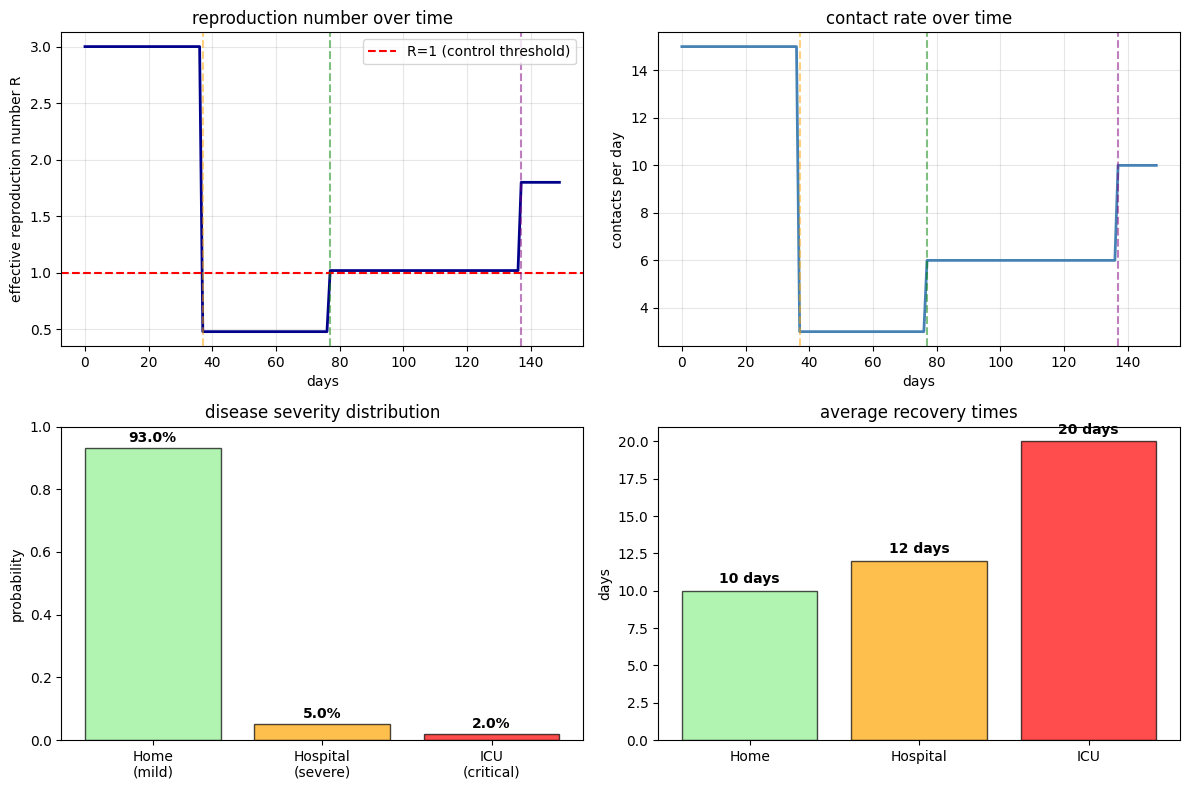

In [43]:

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# plot 1: R0 vs contacts and alpha
days_sim = np.arange(0, 150)
c_timeline = np.ones(150) * c_normal
alpha_timeline = np.ones(150) * alpha_normal

# apply lockdown changes
c_timeline[lockdown_start:lockdown_relax] = c_lockdown
alpha_timeline[lockdown_start:lockdown_relax] = alpha_lockdown

c_timeline[lockdown_relax:lockdown_end] = c_relax
alpha_timeline[lockdown_relax:lockdown_end] = alpha_relax

c_timeline[lockdown_end:] = c_end
alpha_timeline[lockdown_end:] = alpha_end

# calculate R over time
R_timeline = (c_timeline * alpha_timeline) / beta_weighted

axes[0, 0].plot(days_sim, R_timeline, linewidth=2, color='darkblue')
axes[0, 0].axhline(1.0, color='red', linestyle='--', label='R=1 (control threshold)')
axes[0, 0].axvline(lockdown_start, color='orange', linestyle='--', alpha=0.5)
axes[0, 0].axvline(lockdown_relax, color='green', linestyle='--', alpha=0.5)
axes[0, 0].axvline(lockdown_end, color='purple', linestyle='--', alpha=0.5)
axes[0, 0].set_xlabel('days')
axes[0, 0].set_ylabel('effective reproduction number R')
axes[0, 0].set_title('reproduction number over time')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# plot 2: contact rate over time
axes[0, 1].plot(days_sim, c_timeline, linewidth=2, color='steelblue')
axes[0, 1].axvline(lockdown_start, color='orange', linestyle='--', alpha=0.5)
axes[0, 1].axvline(lockdown_relax, color='green', linestyle='--', alpha=0.5)
axes[0, 1].axvline(lockdown_end, color='purple', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('days')
axes[0, 1].set_ylabel('contacts per day')
axes[0, 1].set_title('contact rate over time')
axes[0, 1].grid(True, alpha=0.3)

# plot 3: severity distribution
severity_labels = ['Home\n(mild)', 'Hospital\n(severe)', 'ICU\n(critical)']
severity_values = [p_h, p_s, p_c]
colors = ['lightgreen', 'orange', 'red']

axes[1, 0].bar(severity_labels, severity_values, color=colors, alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('probability')
axes[1, 0].set_title('disease severity distribution')
axes[1, 0].set_ylim(0, 1)
for i, v in enumerate(severity_values):
    axes[1, 0].text(i, v + 0.02, f'{v*100:.1f}%', ha='center', fontweight='bold')

# plot 4: recovery times
recovery_labels = ['Home', 'Hospital', 'ICU']
recovery_days = [1/beta_h, 1/beta_s, 1/beta_c]
colors = ['lightgreen', 'orange', 'red']

axes[1, 1].bar(recovery_labels, recovery_days, color=colors, alpha=0.7, edgecolor='black')
axes[1, 1].set_ylabel('days')
axes[1, 1].set_title('average recovery times')
for i, v in enumerate(recovery_days):
    axes[1, 1].text(i, v + 0.5, f'{v:.0f} days', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()